In [1]:
import eodslib
from datetime import datetime
from pathlib import Path
import rasterio
import numpy
from rasterio.plot import show
from rasterio.plot import show_hist
from matplotlib import pyplot
from dotenv import load_dotenv
import os

In [ ]:
# USER MUST EDIT THE ENVIRONMENT FILE REFERENCED BELOW, OR CREATE THEIR OWN FILE AND REFERENCE IT
load_dotenv('sample.env')

In [ ]:
# set configuration based on contents of the ENVIRONMENT FILE.
conn = {
    'domain': os.getenv("HOST"),
    'username': os.getenv("API_USER"),
    'access_token': os.getenv("API_TOKEN"),
    }

In [ ]:
# use default path to local "output" directory
output_dir = eodslib.make_output_dir(Path.cwd() / 'output')

In [3]:
# user defined keyword arguments (kwargs)
cat_search_geom_wgs84wkt_query = 'POLYGON((-1.18 50.94, -1.18 50.86, -1.06 50.86, -1.06 50.94, -1.18 50.94))'
cutting_geom_osgbwkt = 'POLYGON((455556 114292, 455556 106403, 467913 106403, 467913 114292, 455556 114292))'

In [ ]:
# example of keyword argument (kwarg) expansion, the input needs to be a python dictionary

eods_params = {
    'output_dir':output_dir,
    'start_date':'2020-01-01',
    'end_date':'2020-09-01',
    'title':'ORB137',
    'geom':cat_search_geom_wgs84wkt_query,
    'cloud_min':0,
    'cloud_max':20,
    'ignore_split_granules':True,
    'sat_id':2,
    }

list_of_layers, df = eodslib.query_catalog(conn, **eods_params)

In [ ]:
# create an empty list of results
list_of_results = list()

# iterative through the returned EODS query list of layers
for lyr in list_of_layers:
    
    wkt = df.loc[(df['alternate'] == lyr)]['csw_wkt_geometry'].item()
    lower_left, upper_right = eodslib.get_bbox_corners_from_wkt(wkt,27700)

    config_wpsprocess = {
         'template_xml':'rascropcoverage_template.xml',
         'xml_config':{
            'template_layer_name':lyr,
            'template_mimetype':'image/tiff',
            'template_ll':str(lower_left.x) + ' ' + str(lower_left.y),
            'template_ur':str(upper_right.x) + ' ' + str(upper_right.y),
            'template_clip_geom':cutting_geom_osgbwkt
            },
         'dl_bool':True
        }

    # for each layer, call the run wps function which:
        # submits the WPS job
        # polls the wps server until the job is READY
        # downloads the result (and retries up to 3 times if there's a break in the download connection)
    execution_dict = eodslib.run_wps(conn, config_wpsprocess, output_dir=output_dir)

    # append the execution dictionary to the results list
    list_of_results.append(execution_dict)

# log the output to a log csv file
eodslib.output_log(list_of_results)

In [ ]:
# override path list for specific S2 ARD outputs
list_download_paths = [ii for ii in output_dir.glob('**/*osgb_vmsk_sharp_rad_srefdem_stdsref.tif*')];list_download_paths

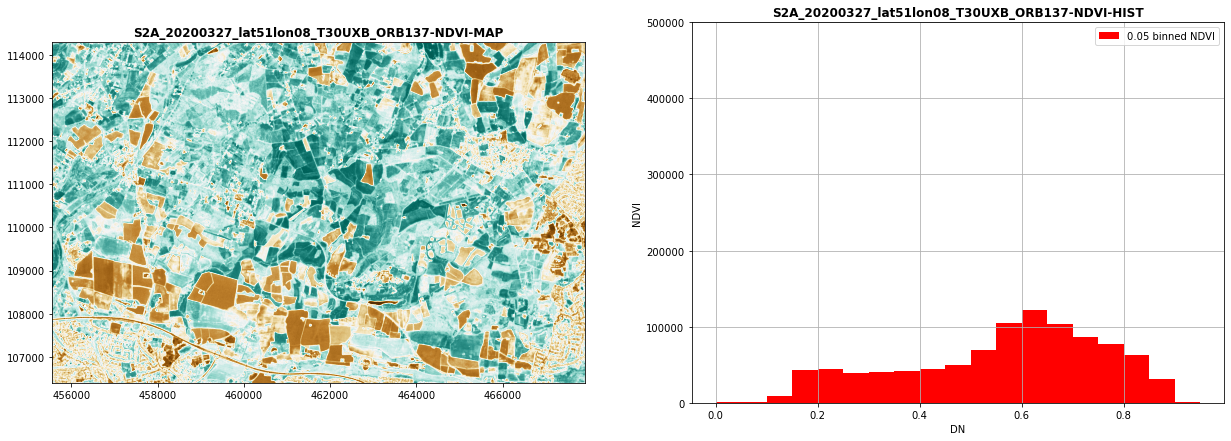

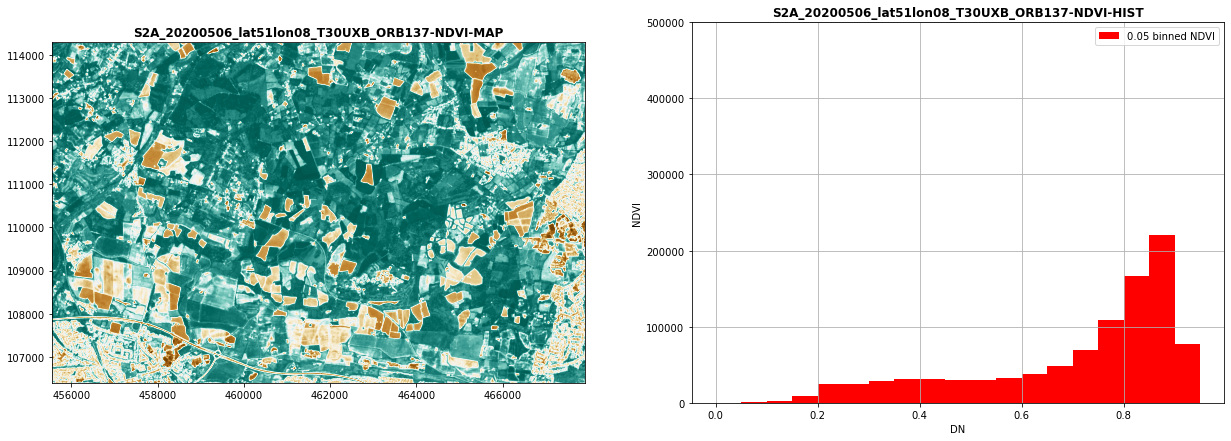

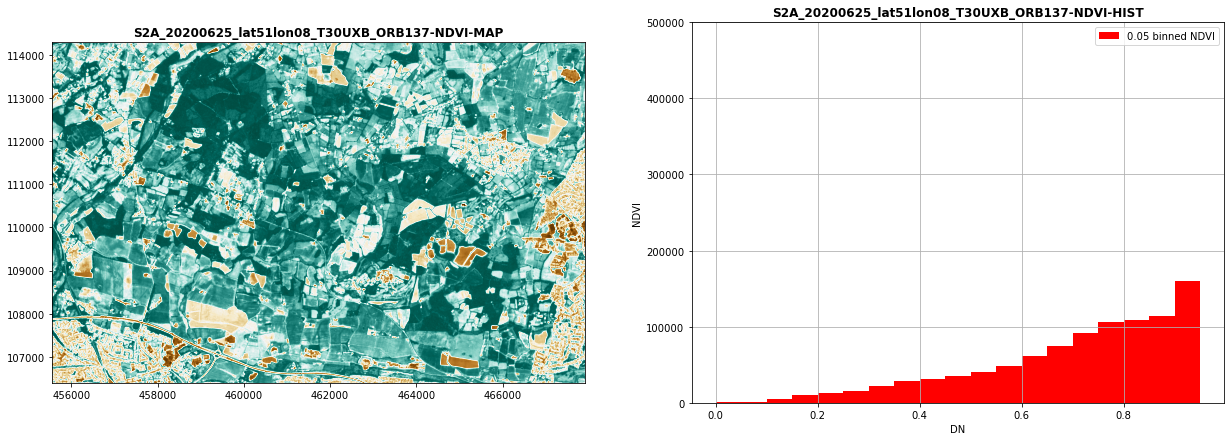

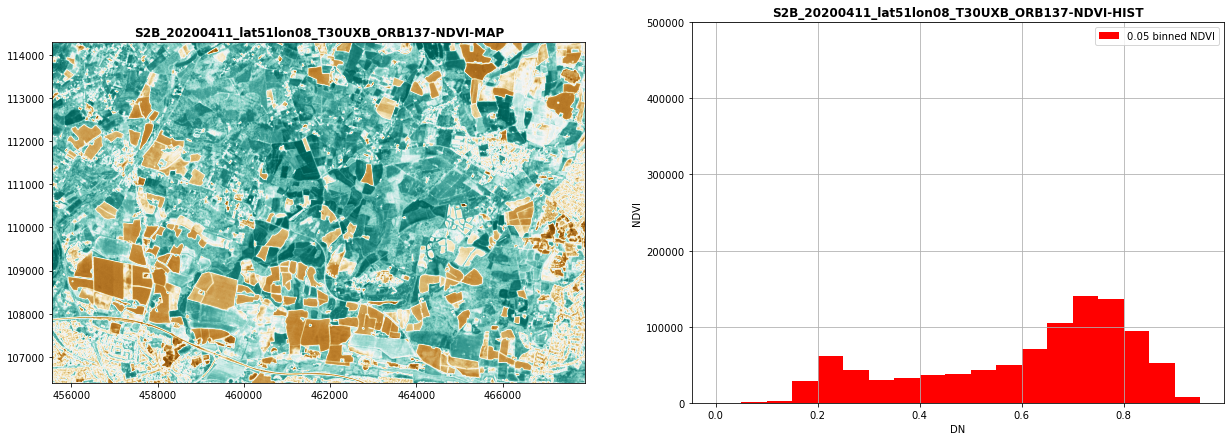

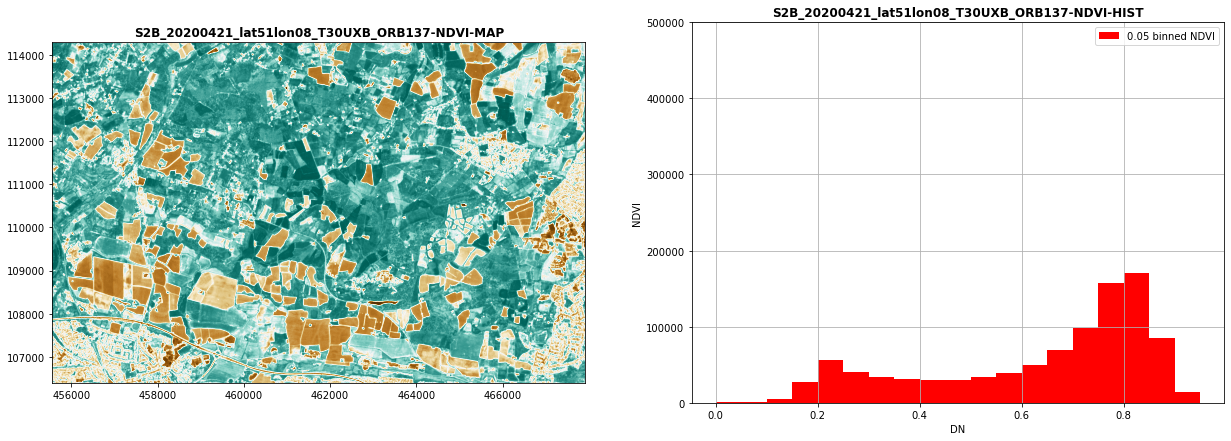

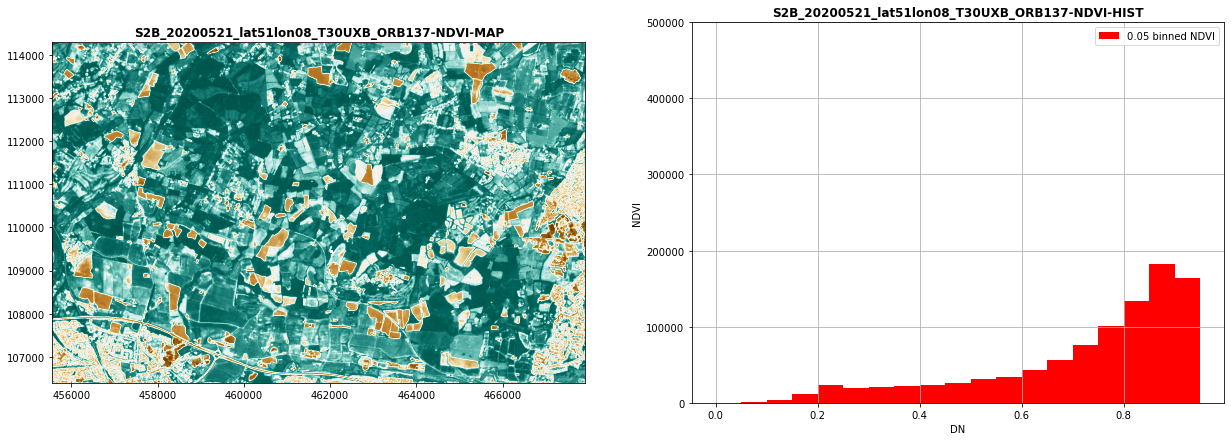

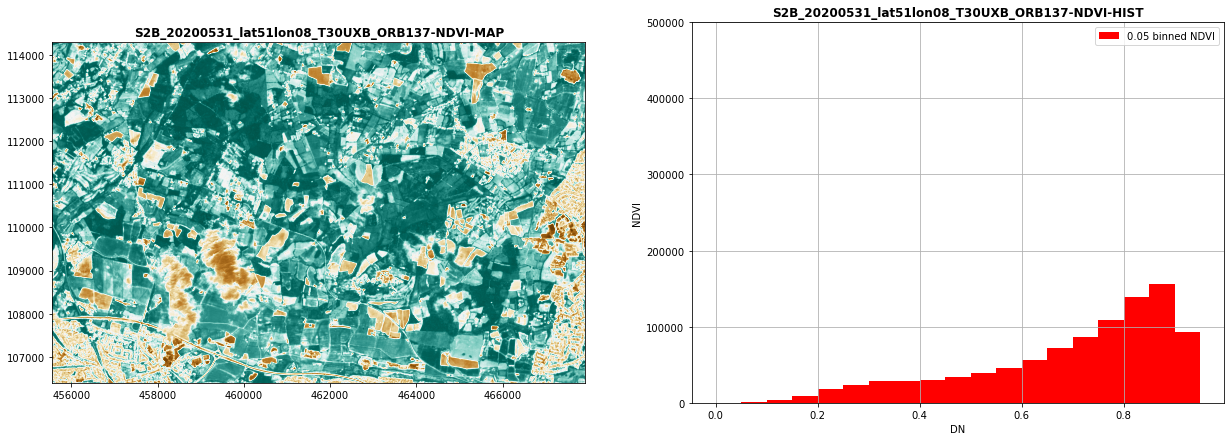

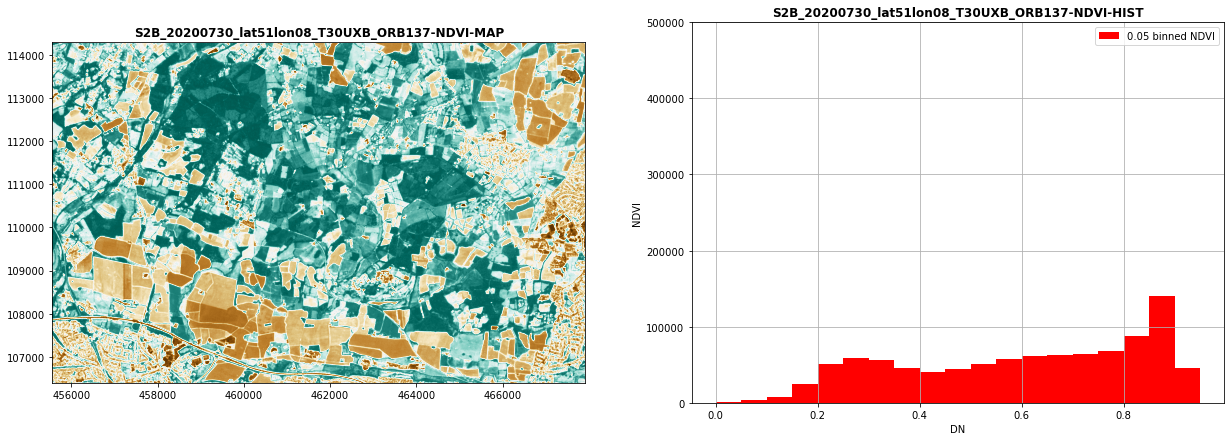

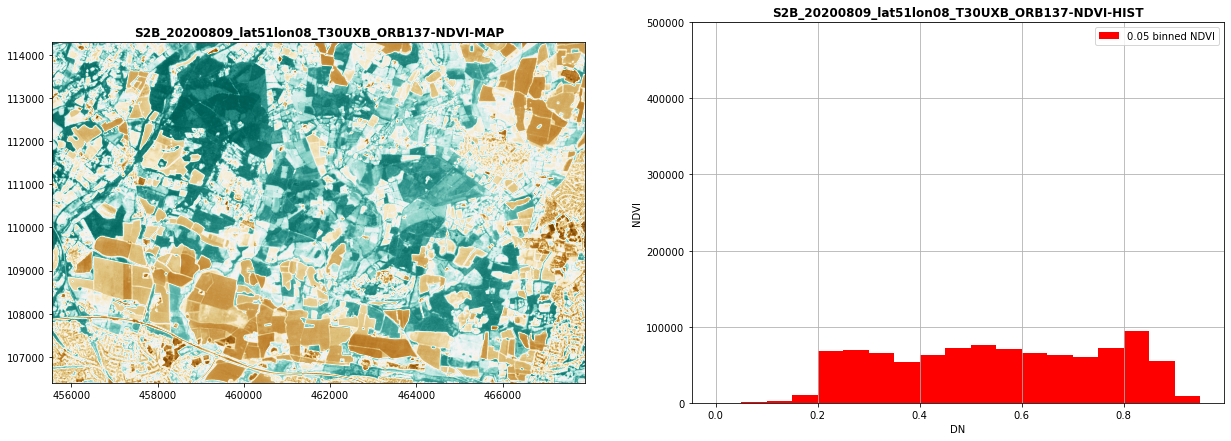

In [8]:
# POST-PROCESSING EXAMPLE
#        calc ndvi from s2 10-band granule
#        make nice 2-panel plot of chorolopeth and histogram of values

def make_2_panel_raster_plot(ard_name, ard_data, ndvi_hist_bins):
    """
    Add a two-panel plot to the fig for NDVI map and histogram
    """
    
    fig, (ax1, ax2) = pyplot.subplots(1,2, figsize=(21,7))
    the_map = show((ard_data, 1), ax=ax1, transform=ard_data.transform, cmap='BrBG', title=ard_name + '-NDVI-MAP',clim=(0,1));    
    
    show_hist(ard_data, ax=ax2, bins=ndvi_hist_bins, lw=0.0, stacked=False,histtype='stepfilled', title=ard_name + '-NDVI-HIST')
    ax2.set_ylim([0,500000])
    ax2.legend(['0.05 binned NDVI'])
    ax2.set_ylabel('NDVI')
     
def check_for_nodata_in_aoi(ard_data, ifile):
    """
    Check if NDVI band has an array of ZERO values (meaning the Area of Interest intersets a ZERO area
    """
       
    # if max of the array = 0, then it's all "no data"
    if numpy.nansum(ard_data.read(1)) == 0:
        print(' ### WARNING This file contains NO data :: ' + str(ifile))
        return False
    else:
        return True
      
def calc_ndvi(input_tif, output_dir=Path.cwd()):
    """
    calc ndvi from input 10-band S2 ARD
    """

    path_ndvi = output_dir / str(str(input_tif.stem) + '-ndvi.tif')

    try:
        with rasterio.open(input_tif) as src:
            band_red = src.read(3)
            band_nir = src.read(7)
            profile = src.profile

        # Allow division by zero
        numpy.seterr(divide='ignore', invalid='ignore')

        # calc ndvi
        ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

        # update rasterio obj metadata
        profile.update(
            dtype=rasterio.float32,
            count = 1,
            compress='lzw')

        with rasterio.open(path_ndvi, 'w', **profile) as dst:
            dst.write(ndvi.astype(rasterio.float32), 1)
        
        return path_ndvi
        
    except Exception as err:
        print(err)
        return
   
    
def main():    
        
    if list_download_paths is not None:

        # set ndvi histogram bins
        ndvi_hist_bins = numpy.arange(0, 1, 0.05)
        
        # for each ard tiff
        for item in list_download_paths:
            
            # calc ndvi 
            path_ndvi = calc_ndvi(item, output_dir=output_dir)
            
            # set plot title and open rasterio item
            ard_name = str(path_ndvi.stem).split('_utm30n')[0]
            ard_data = rasterio.open(path_ndvi)

            # check to see if the ndvi is NOT a "zero array"
            check_bool = check_for_nodata_in_aoi(ard_data, path_ndvi)
            if check_bool:

                # call plot function
                make_2_panel_raster_plot(ard_name, ard_data, ndvi_hist_bins)
                pyplot.show()
                
main()

In [ ]:
print('### Script Finished')